In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

from ping.research.data import get_all_data, map_colors, strip_prefix

data = get_all_data('desikan')
data.filter(lambda k, v: k.startswith('MRI_cort_area') or k.startswith('MRI_cort_thick') or k.startswith('DTI_fiber_vol') or 'gender' in k.lower())
data.filter(lambda k, v: k.endswith('LH_PLUS_RH') or k == 'Gender')
data.filter(lambda k, v: 'fuzzy' not in k)

Computing derived data...
PCA data matrix size: (447, 1119)


In [42]:
len(data.data_dict.keys())

92

In [43]:
import copy
import numpy as np

mydata = copy.deepcopy(data.data_dict)
del mydata['SubjID']

y = mydata['Gender']
y = 2 * (y == 'F') - 1
del mydata['Gender']

X = np.asarray(mydata.values(), dtype=float).T
X_lbl = np.asarray(mydata.keys())

# Remove nan columns
np.any(np.isnan(X).sum(axis=0) == X.shape[0])
# Remove nan subjects
good_idx = np.isnan(X).sum(axis=1) == 0
X = X[good_idx]
y = y[good_idx]
X.shape, np.unique(y)

((1119, 90), array([-1,  1]))

55
25


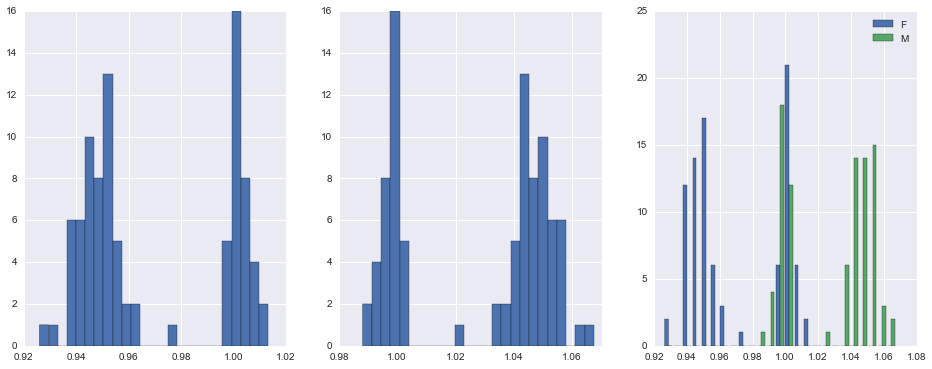

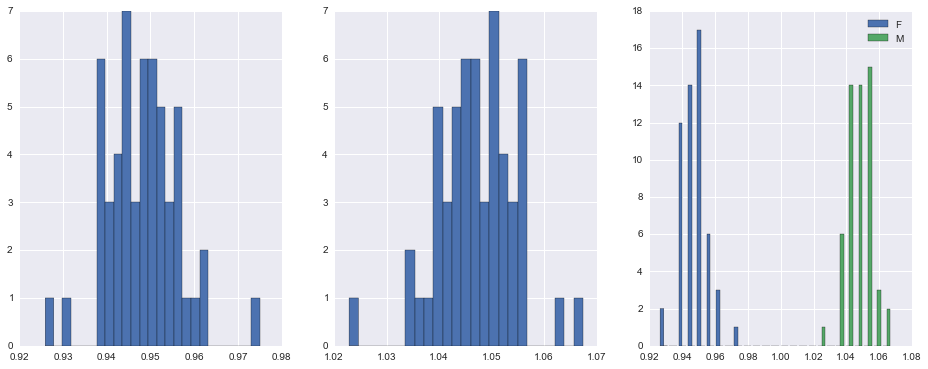

In [44]:
# Select data with different means
female_data = X[y==1]
male_data = X[y==-1]
all_means = X.mean(axis=0)
female_norm_means = female_data.mean(axis=0) / all_means
male_norm_means = male_data.mean(axis=0) / all_means

plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.hist(female_norm_means, 25)
plt.subplot(1,3,2)
plt.hist(male_norm_means, 25)
plt.subplot(1,3,3)
plt.hist([female_norm_means, male_norm_means], 25)
plt.legend(['F', 'M'])

# Now choose only the well-split features
split_feat_idx = np.abs(female_norm_means - 1) > 0.025
print(split_feat_idx.sum())

plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.hist(female_norm_means[split_feat_idx], 25)
plt.subplot(1,3,2)
plt.hist(male_norm_means[split_feat_idx], 25)
plt.subplot(1,3,3)
plt.hist([female_norm_means[split_feat_idx],
          male_norm_means[split_feat_idx]], 25)
plt.legend(['F', 'M'])

# select the 25 most different values.
idx = np.argsort(np.abs(1 - female_norm_means[split_feat_idx]))
split_feat_idx = np.zeros(split_feat_idx.shape, dtype=bool)
split_feat_idx[idx[-25:]] = True
print(split_feat_idx.sum())
#X = X[:, split_feat_idx]
#X_lbl = np.asarray(X_lbl)[split_feat_idx]


90


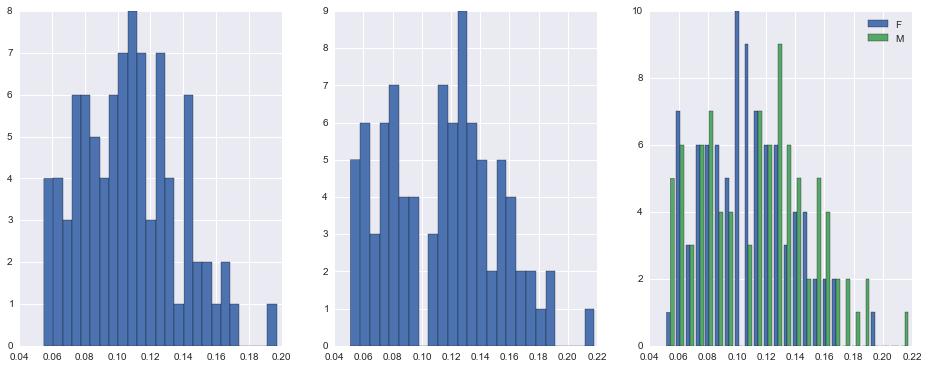

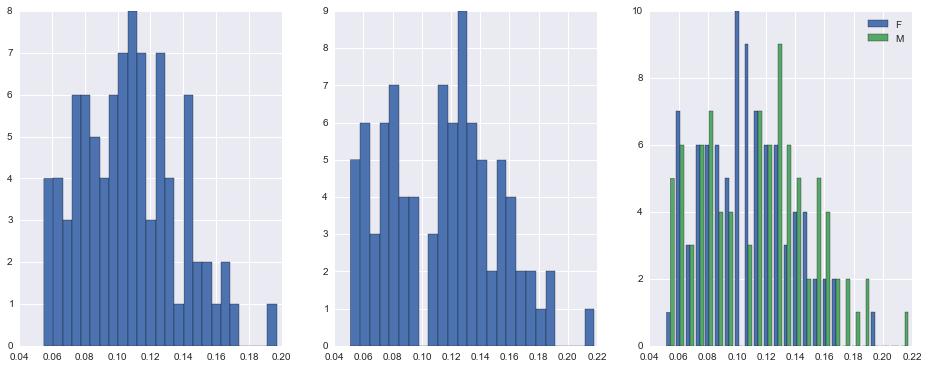

In [45]:
# Look at the std distributions
female_data = X[y==1]
male_data = X[y==-1]
all_stds = X.mean(axis=0)
female_norm_stds = female_data.std(axis=0) / all_stds
male_norm_stds = male_data.std(axis=0) / all_stds

plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.hist(female_norm_stds, 25)
plt.subplot(1,3,2)
plt.hist(male_norm_stds, 25)
plt.subplot(1,3,3)
plt.hist([female_norm_stds, male_norm_stds], 25)
plt.legend(['F', 'M'])

# Now choose only the well-split features
split_feat_idx = np.abs(female_norm_stds) > 0
print(split_feat_idx.sum())

plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.hist(female_norm_stds[split_feat_idx], 25)
plt.subplot(1,3,2)
plt.hist(male_norm_stds[split_feat_idx], 25)
plt.subplot(1,3,3)
plt.hist([female_norm_stds[split_feat_idx],
          male_norm_stds[split_feat_idx]], 25)
plt.legend(['F', 'M'])



Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 fe

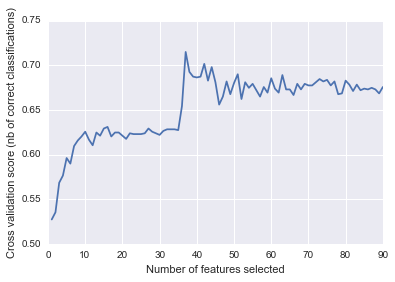

In [46]:
from sklearn.linear_model import LogisticRegression

svc = LogisticRegression()#(kernel="rbf")
svc.fit(X, y)

from sklearn.cross_validation import StratifiedKFold
from sklearn.feature_selection import RFECV

# Create the RFE object and compute a cross-validated score.

# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(y, 2),
              scoring='accuracy', verbose=10)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)


In [49]:
print rfecv.grid_scores_, rfecv.ranking_, rfecv.support_, rfecv.n_features_
print(X_lbl[rfecv.support_])
print(X_lbl[~rfecv.support_])


[ 0.52726009  0.53531338  0.56837145  0.57642634  0.5960676   0.58980961
  0.60946524  0.61572642  0.62017953  0.62554945  0.61662088  0.61036449
  0.62466618  0.62108516  0.62913525  0.63092576  0.62018592  0.6246518
  0.62465819  0.62109475  0.61751533  0.62377013  0.62287567  0.62287887
  0.62288046  0.62377013  0.62913046  0.62555265  0.62376693  0.62197962
  0.62645029  0.62823601  0.62823601  0.62823601  0.62734315  0.6541688
  0.71490544  0.69258721  0.68722687  0.68633881  0.68722527  0.70153335
  0.68274502  0.69792838  0.6809625   0.65592576  0.66486871  0.68184896
  0.66756964  0.68007603  0.68990065  0.66218055  0.68095132  0.67469173
  0.6791688   0.67202913  0.66487829  0.67560216  0.66933619  0.68542199
  0.67380686  0.66933299  0.68900939  0.6729172   0.672914    0.66666081
  0.67917199  0.67292039  0.67917039  0.67738628  0.67738787  0.6809593
  0.68453552  0.68185376  0.68363787  0.67738628  0.68185376  0.66755207
  0.66845291  0.68274182  0.67827754  0.67113148  0.67

(1119, 126)


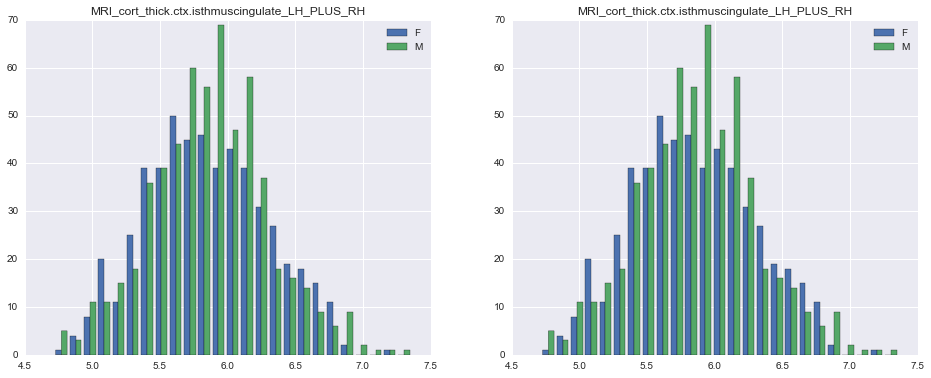

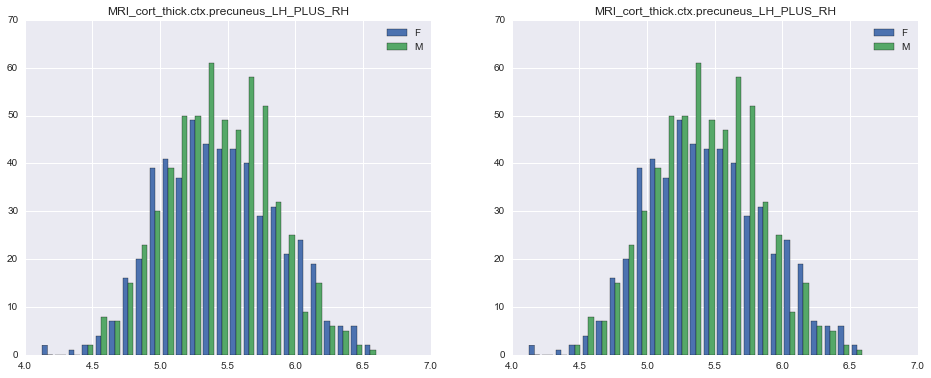

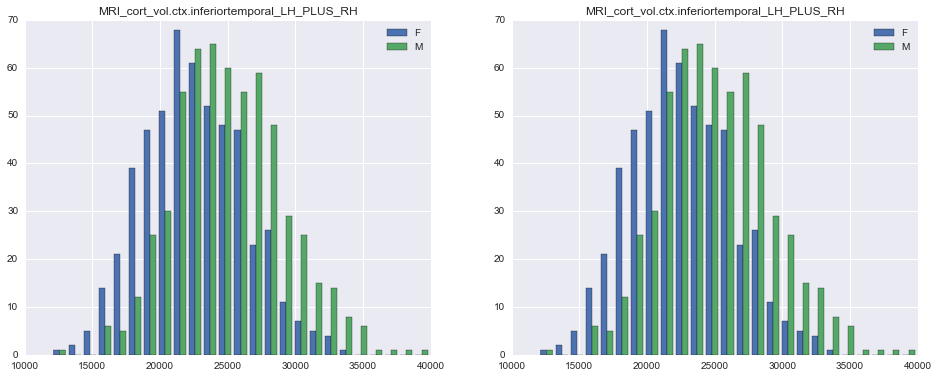

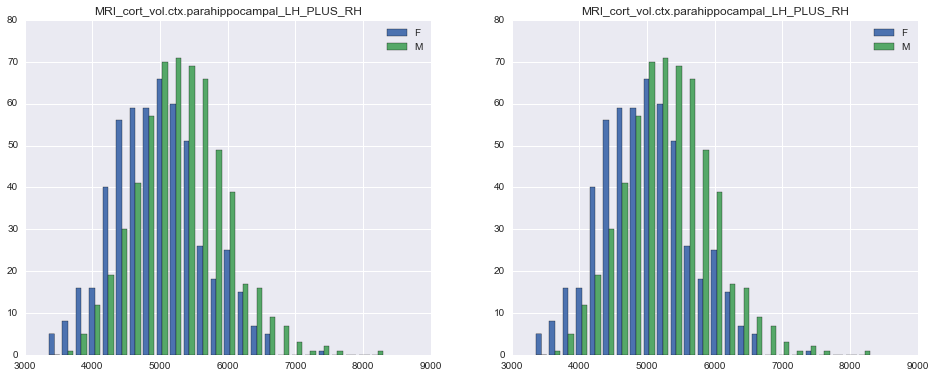

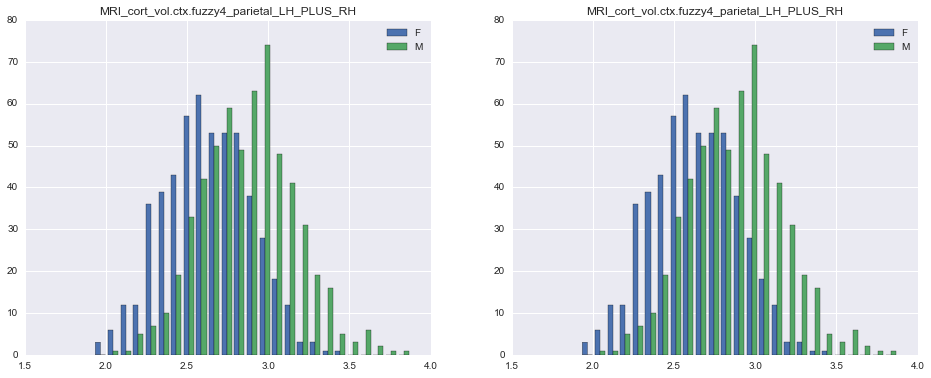

In [27]:
print(X.shape)
feat_indices = np.random.randint(0, X.shape[1], 5)
for idx in feat_indices:
    plt.figure(figsize=(16,6))

    plt.subplot(1,2,1)
    plt.hist([X[y==1, idx], X[y==-1, idx]], 25)
    plt.title(X_lbl[idx])
    plt.legend(['F', 'M'])

    plt.subplot(1,2,2)
    plt.hist([X[y==1, idx], X[y==-1, idx]], 25)
    plt.title(X_lbl[idx])
    plt.legend(['F', 'M'])
